In [435]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier



import matplotlib.pyplot as plt


In [412]:
df_selftext = pd.read_csv('../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,cost of moving bitcoin off an exchange i decid...
1,0,the new financial system is closer to fruition...


In [413]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    2846
1     748
Name: subreddit, dtype: int64


0    7038
1    1981
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [414]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik wa ha amp text would get llet like nt know one use think http'.split())


# Model

In [415]:
X = df_selftext.text
y = df_selftext.subreddit

In [416]:
y.value_counts(normalize=True)

0    0.791875
1    0.208125
Name: subreddit, dtype: float64

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [418]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    #('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [419]:
nb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'nb__alpha': [.01, .05, .1, .25, .5, .1]
    #'cvec__max_features': range(2500, 3500, 100),
    #'cvec__min_df': range(1,5),
    #'cvec__max_df': [i/100 for i in range(0, 100, 5)],
    #'cvec__ngram_range': [(1,1),(1, 2), (1,3)]
}

In [420]:
rs = RandomizedSearchCV(nb_pipe, 
                  nb_pipe_params, 
                    cv = 5) 

In [421]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   param_distributions={'nb__alpha': [0.01, 0.05, 0.1, 0.25,
                                                      0.5, 0.1],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', 

In [422]:
#using all stopwords lowers scores to 0.8823747680890538 / 0.8654060066740823

print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.8879406307977736


0.8698553948832035

In [423]:
rs.best_params_

{'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again'

In [424]:
rs.score(X_test, y_test)

0.8698553948832035

In [425]:
preds = rs.predict(X_test)

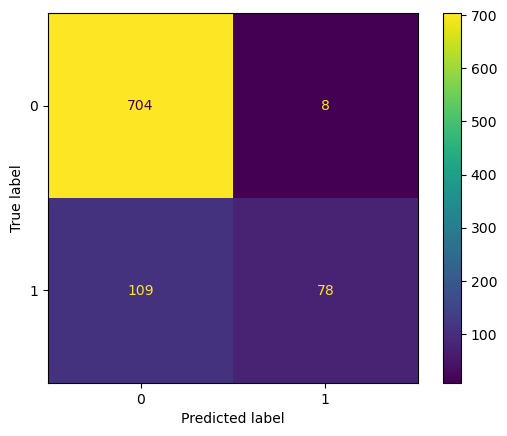

In [426]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

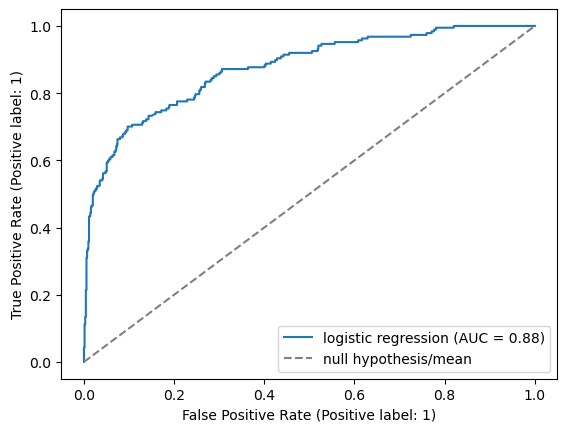

In [427]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='logistic regression')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

In [428]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.676732,0.323268,0
1,0.939399,0.060601,0
2,0.900003,0.099997,0
3,0.186423,0.813577,1
4,0.979752,0.020248,0


In [429]:
bitcoinish_indexes = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [430]:
for i in df_selftext.iloc[bitcoinish_indexes].text:
    print(i,'\n')

what's the best investment plan for bitcoin just buy and hodl or sell every high and buy in every low 

bitcoin rationality and god i have a with a few bitcoin in it today i learned that there is an extremely small chance that some in my lifetime and at any time during my lifetime this second or year from now could accideally or forcibly get io my a i meid the chance of that is extremely small suppose winning the jackpot twice in a row btw i didn't cou this probability i made it up reddit mathematician be understanding in any case the very realization that bitcoins in an accou are not a certain thing is strange to me on the hand it would be unreasonable to defend against this risk for emple by diversifying private key and on the other hand there is alys a chance that some person will pay this tax on the existence of god and never find out about it i accept this but i am curious how do you guy deal with it 

help with decision on invest all in btc after canceling apartment purchase i ho

In [431]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [432]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['bitcoin'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

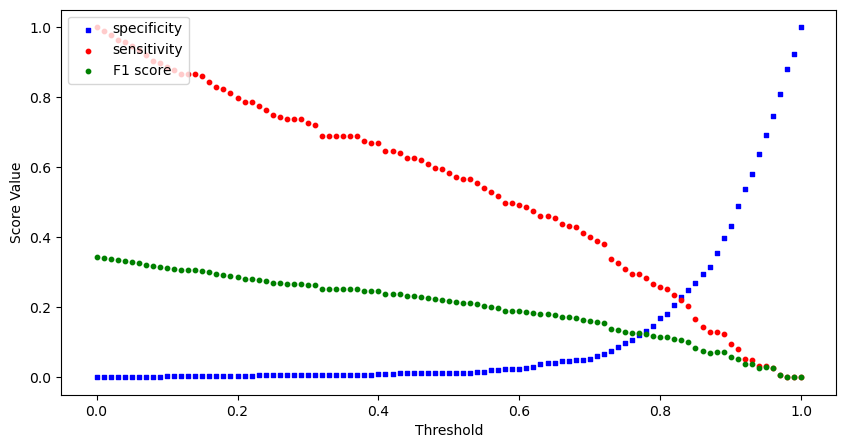

<Figure size 640x480 with 0 Axes>

In [433]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
